**Author:** [Martina Cinquini](http://pages.di.unipi.it/cinquini/)  
**Python version:**  3.8 <br>
**Last update:** 11/22/21

# **NCDA** - **N**onlinear **C**ausal **D**iscovery with **Apriori**

### Table of Contents

* [Introduction to Causal Discovery (CD)](#section1)
    * [Nonlinear CD with Additive Noise Models](#section_1_1)
    * [Example](#section_1_2)
    * [Pros & Cons](#section_1_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)
    * [Section 1.2.3](#section_1_2_3)

### Introduction to Causal Discovery <a class="anchor" id="section1"></a>

Given a dataset $X$, the objective of causal discovery is to infer as much as possible about the mechanism generating the data. In particular, the goal is to discover the graph $G$ modeling the dependencies among variables.
<br><br>
<div>
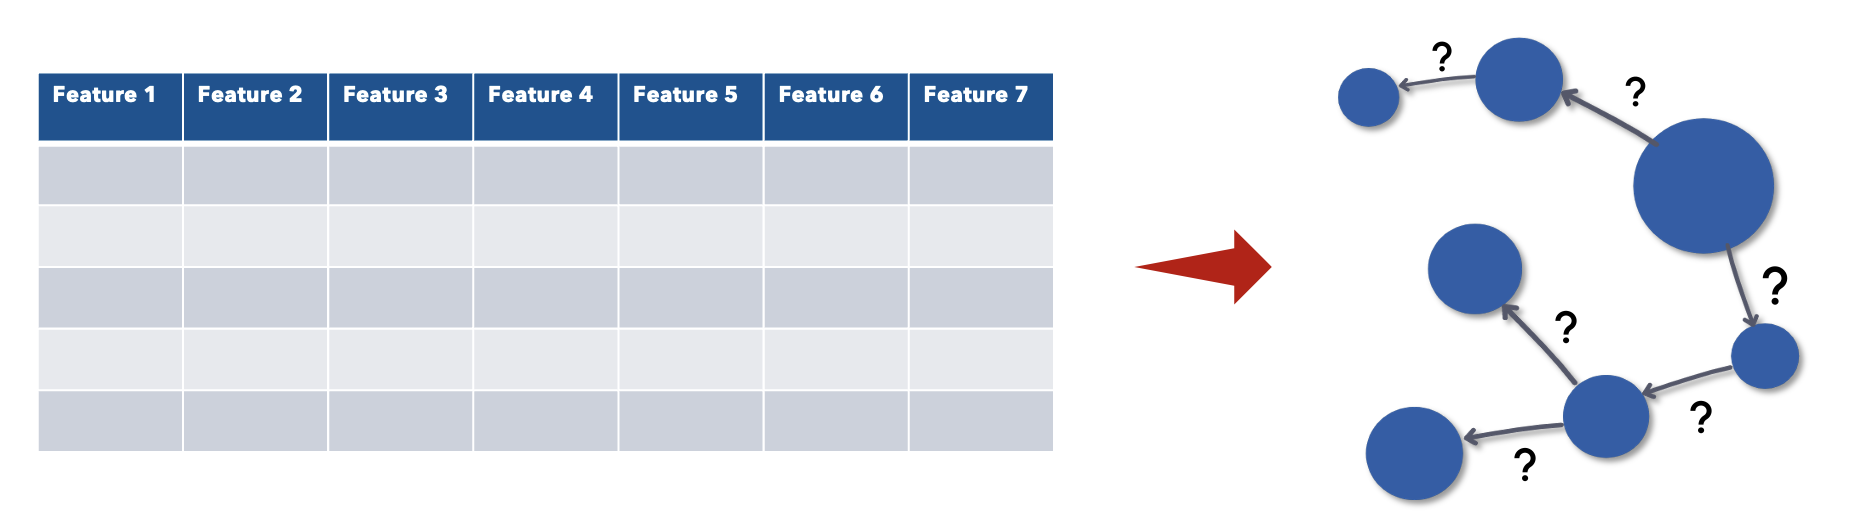
</div>

#### Nonlinear CD with additive noise models<a class="anchor" id="section1_1"></a>
As starting point for our project we adopt a specific procedure called [Nonlinear Causal Discovery (NCD)](https://papers.nips.cc/paper/2008/file/f7664060cc52bc6f3d620bcedc94a4b6-Paper.pdf) originally proposed by
Hoyer et al. that demonstrates that nonlinearities in the data generation process allow more accurate information of the causal system to be identified.

They assume that the observed data has been generated in the following way:
<br>
each feature $x^{(j)}$ is associated with a node $j$ in $G$, and the values of $x^{(j)}$ are obtained as a function of its parents in $G$, plus some independent additive noise $\nu^{(j)}$, i.e., <br>
<br>
\begin{equation}
\label{eq:hoyer}
    x^{(j)} = f_j(\mathit{pa}(j)) + \nu^{(j)}
\end{equation}
<br>
where $f_j$ is an arbitrary function (possibly different for each $j$), $\mathit{pa}(j)$ is a vector containing the elements $x^{(j)}$ such that there is an edge from $i$ to $j$ in $G$, i.e., $\mathit{pa}(j)$ returns the parents of $j$.

We now consider practical estimation methods which infer the generating graph from sample data. We consider the case of two variables.
- With the function estimated by the regressor we calculate the residuals,
- We test for independence between the residuals and the independent variable.
- If the residuals and the independent variable are independent, we accept the model
- otherwise, we reject it.
We apply the same procedure to the reverse model.
The procedure will result in one of several possible scenarios.
1. First, if the variables are statistically independent we infer that there is no causal relationship between the two and no further analysis is performed.
2. If they are dependent but both directional models are accepted we conclude that either model may be correct but we cannot infer it from the data.
3. Neither direction is consistent with the data so the generating mechanism cannot be described using this model.
4. Finally, we can reject one of the directions and accept the other.

#### Example - Abalone Dataset<a class="anchor" id="section1_2"></a>

In [28]:
import os
import pandas as pd

Let's analyze a possible application of the methodology. The object of investigation is an open-source dataset from the UCI repository concerning the [abalone](https://archive.ics.uci.edu/ml/datasets/abalone), a group of shellfish.

In [57]:
directory = os.path.realpath(os.path.dirname("GENCDA"))
file_path = os.path.join(os.path.dirname(directory), "datasets", "abalone.csv")
dataset = pd.read_csv(file_path) # Abalone Data
df = dataset.sample(500) # Sample of 500 instances
df.head()

,Rings,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
1664,9,0.605,0.470,0.145,0.8025,0.3790,0.2265,0.2200
3913,11,0.540,0.400,0.145,0.7570,0.3150,0.1810,0.2150
1180,11,0.655,0.515,0.160,1.3100,0.5530,0.3690,0.3450
865,10,0.605,0.475,0.175,1.3820,0.6090,0.2325,0.3985
4141,11,0.650,0.505,0.165,1.3570,0.5725,0.2810,0.4300


Ground Truth


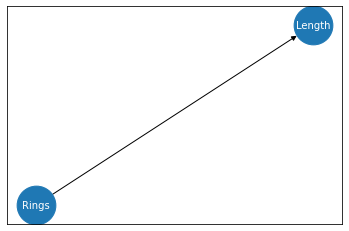

In [58]:
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from([('Rings', 'Length')])
print('Ground Truth')
nx.draw_networkx(graph, node_size=1500, font_color='w', font_size=10)

Specifically, variables considered are:
* The number of rings in the abalone shell that indicate their age
* The length of the shell

In [59]:
%load_ext autoreload
%autoreload 2
from causal_discovery.hoyer import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


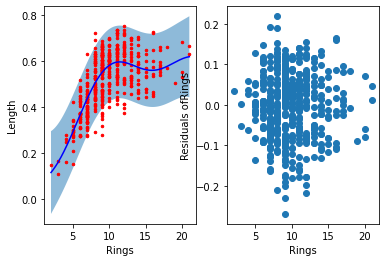

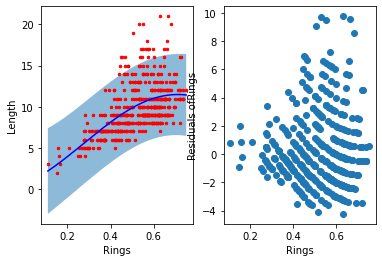

In [73]:
# To run causal discovery, we create a NonlinearANM object                                                                                          1e-10, 1e+1))
obj = NonlinearANM(df) 

index_rings = 0
index_length = 1

kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Finally, we call the fit method for the case of two variables 
p_value_general, p_value_fm, p_value_bm = obj.fit_bivariate(index_rings, index_length, kernel=kernel, show_plots=True)

In [55]:
obj.evaluate(p_value_general, p_value_fm, p_value_bm)

Rings causes Length


In [25]:
print(f'Independence test between Rings and Length: {general_pvalue}')
print('\n')
print(f'Independence test between Rings and its residuals: {pvalue_rings}')
print('\n')
print(f'Independence test between Length and its residuals: {pvalue_length}')

Independence test between Rings and Length: 0.0


Independence test between Rings and its residuals: 0.0661061193460617


Independence test between Length and its residuals: 1.0104094561036447e-08


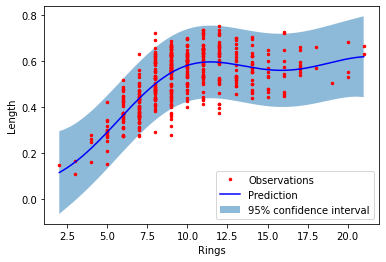

In [69]:
X = df[['Rings']].values.reshape(-1,1)
y = df[['Length']].values.reshape(-1,1)
x = np.linspace(min(X), max(X), 1000).reshape(-1, 1)

kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X, y)

y_pred, sigma = gpr.predict(x, return_std=True)
sigma = sigma.reshape(-1, 1)

plt.figure()
plt.plot(X, y, 'r.', markersize=5, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x.reshape(-1), 
                 np.reshape(y_pred - 1.9600 * sigma, -1), 
                 np.reshape(y_pred + 1.9600 * sigma, -1), 
                 alpha=.5, label='95% confidence interval')

plt.xlabel('Rings')
plt.ylabel('Length')
#plt.xlim(4.9, 25)
#plt.ylim(min(y), max(y))
plt.legend()

plt.show()